In [42]:
import numpy as np
from rumor_centrality import graph_simulations
from rumor_centrality import graph_generator
from tqdm import tqdm
from matplotlib import pyplot as plt
import rumor_centrality.jordan_center_alternative as jo

from rumor_centrality import rumor_detection
import networkx as nx

def predict_center(infected_graph_adj):
    return rumor_detection.get_center_prediction(rumor_detection.networkx_graph_to_adj_list(infected_graph_adj), use_fact=False)

def get_hop_distance(g, center: int, predicted_center: int, diameter):
    if not g.has_node(center) or not g.has_node(predicted_center):
        print("Center of predicted center not in graph")
    if not is_connected(g):
        return -1
    dist = nx.shortest_path_length(g, center, predicted_center)
    if diameter is not None:
        return dist / diameter
    else:
        return dist

def is_connected(g: nx.Graph) -> bool:
    return nx.is_directed(g) and nx.is_strongly_connected(g) or not nx.is_directed(g) and nx.is_connected(g)

def predict(model_conf, predictor_conf, graphs, use_avg, normalized):
    predictor, can_handle_unconnected = predictor_conf
    graph_i, model = model_conf
    graph = graphs[graph_i]
    g, diameter = graph
    infection, center = model
    if len(infection.nodes) == 0:
        return -1

    if not can_handle_unconnected and not is_connected(infection):
        return -1

    predicted = predictor(infection)
    if len(predicted) == 0:
        print("Predicted zero centers")
        return -1

    if use_avg:
        return np.array([get_hop_distance(g, center[0], p, diameter) for p in predicted]).mean()
    else:
        return get_hop_distance(g, center[0], predicted[0], diameter)

def run_sim(times, count, sim, graphs):
    models = []
    for _ in range(times):
        for g, graph in enumerate(graphs):
            models.append((g, sim(graph[0], count)))
    return models

def frequencies(predictions):
    values = [-1 if v is None else v for v in predictions]
    uniq_values = list(set(values))
    return dict([(u, values.count(u)) for u in uniq_values])

def matrix(n, m, p, data, row_names, col_names, max, tick_freq):
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(12, 8), sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for ax in axes.flat:
        ax.set_xlim([-1.5, max[0] + 0.5])
        ax.set_ylim([0, max[1]])
        ax.xaxis.set_ticks(np.arange(-1, max[0] + 1, tick_freq[0]))
        ax.yaxis.set_ticks(np.arange(0, max[1] + 1, tick_freq[1]))

    width = 0.25
    for row in range(n):
        for col in range(m):
            ax = axes[row, col]
            for bar in range(p):
                ax.bar(np.array(list(data[row][col][bar].keys())) + width * bar + width / 2 - (p * width) / 2, data[row][col][bar].values(), width=width)

            if row == n - 1:
                ax.set(xlabel=col_names[col])
            if col == 0:
                ax.set(ylabel=row_names[row])
    return fig

def valid_and_invalid(data):
    valid_data = [(hops, occurrences) for hops, occurrences in data.items() if hops != - 1]
    invalid_data = [occurrences for hops, occurrences in data.items() if hops == - 1]
    invalid_occurrences = sum(invalid_data)
    return valid_data, invalid_occurrences

def mean_of_frequency(data):
    values = []
    for hops, occurrences in data:
        values.extend([hops for _ in range(occurrences)])
    if len(values) == 0:
        return None
    return np.array(values).mean()

def mod_ax(ax, max, tick_freq):
    ax.set_xlim([1, max[0]])
    ax.set_ylim([0, max[1]])
    ax.xaxis.set_ticks(np.arange(0, max[0] + 1, tick_freq[0]))
    ax.yaxis.set_ticks(np.arange(0, max[1], tick_freq[1]))


def avg_matrix(n, m, p, infection_counts, data, row_names, col_names, p_names, max, tick_freq, def_colors=None):
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(12, 8), sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    if n != 1 and m != 1:
        for ax in axes.flat:
            mod_ax(ax, max, tick_freq)
    else:
        mod_ax(axes, max, tick_freq)

    print("Compute invalids and frequency")
    avgs = []
    invalids = []
    for row in range(n):
        avgs.append([])
        invalids.append([])
        for col in range(m):
            avgs[-1].append([])
            invalids[-1].append([])
            for bar in range(p):
                avgs[-1][-1].append([])
                invalids[-1][-1].append([])
                for i in range(len(infection_counts)):
                    valid_freq, invalid_count = valid_and_invalid(data[i][row][col][bar])
                    mean = mean_of_frequency(valid_freq)
                    avgs[-1][-1][-1].append(mean)
                    invalids[-1][-1][-1].append(invalid_count)

    print("Draw")
    if def_colors is not None:
        colors = def_colors
    else:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    print(colors)
    for row in range(n):
        for col in range(m):
            if n == 1 and m == 1:
                ax = axes
            else:
                ax = axes[row, col]
            for bar in range(p):
                ax.plot(np.array(infection_counts), avgs[row][col][bar], color=colors[bar], label=p_names[bar])
                ax.plot(np.array(infection_counts), np.array(invalids[row][col][bar]) / 500 * 10, color=colors[bar], linestyle=":", label=p_names[bar])

            if row == n - 1:
                ax.set(xlabel=col_names[col])
            if col == 0:
                ax.set(ylabel=row_names[row])
    # axes[0, 0].legend()
    return fig


import pickle
import os.path

def save(data, name):
    if not os.path.exists(f"{name}.pickle"):
        with open(f"{name}.pickle", "wb") as f:
            print("Look Morty, I turned myself into a pickle")
            pickle.dump(data, f)

def load(name):
    if os.path.exists(f"{name}.pickle"):
        with open(f"{name}.pickle", "rb") as f:
            return pickle.load(f)


In [3]:
sim_si = lambda g, i: graph_simulations.si(g, -1, 0.3, 1, i, 10, True)
sim_sis = lambda g, i: graph_simulations.sis(g, -1, 0.3, 0.1, 1, i, 10, True)
sim_sir = lambda g, i: graph_simulations.sir(g, -1, 0.3, 0.1, 1, i, 10, True)
simulations = [sim_si, sim_sis, sim_sir]
sim_names = ["SI", "SIS", "SIR"]


rc_prediction = lambda infected_g: predict_center(infected_g)
jo_prediction = lambda infected_g: jo.centers_by_jordan_center(infected_g)
bc_prediction = lambda infected_g: jo.centers_by_betweenness_centrality(infected_g)
dc_prediction = lambda infected_g: jo.centers_by_distance_centrality(infected_g)
# Predictor, can_predict_disconnected
predictors = [(rc_prediction, True), (jo_prediction, False), (bc_prediction, False), (dc_prediction, False)]
predictor_names = ["Rumour Centrality", "Jordan Center", "Betweenness Centrality", "Distance Centrality"]

infection_counts = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

small_world_g = lambda: graph_generator.small_world(1000, 100, 0.1)
scale_free_g = lambda: nx.Graph(graph_generator.scale_free(1000))
synthetic_internet_g = lambda: graph_generator.synthetic_internet(1000)
internet_g = lambda: graph_generator.internet()
us_power_grid_g = lambda: graph_generator.us_power_grid()

graphs_types = [small_world_g, scale_free_g, synthetic_internet_g, us_power_grid_g]
graph_names = ["Small World", "Scale Free", "Synthetic Internet", "US Power Grid"]

# exceptions = [(0, 2, 1), (1, 2, 1), (2, 2, 1)]
graph_counts = 5
simulation_times = 10


In [18]:
def generate_graphs(g, graph_type):
    print(f"Generating graph {graph_names[g]}")
    graphs = []
    while len(graphs) < graph_counts:
        new_graph = graph_type()
        if not is_connected(new_graph):
            print("Graph is not connected, skipping")
        else:
            graphs.append(new_graph)
    print("Calculating Diameters")
    return [(graph, nx.diameter(graph)) for graph in graphs]

graphs = [generate_graphs(g, graph_type) for g, graph_type in enumerate(graphs_types)]

save(graphs, "graphs_2")

Generating graph Small World
Calculating Diameters
Generating graph Scale Free
Graph is not connected, skipping
Calculating Diameters
Generating graph Synthetic Internet
Calculating Diameters
Generating graph US Power Grid
Calculating Diameters
Look Morty, I turned myself into a pickle


In [2]:
graphs = load("graphs_2")
print(len(graphs))

4


In [19]:
print(f"Len: {len(graphs)}")
print(f"Connected Small World: {[is_connected(g[0]) for g in graphs[0]]}")
print(f"Connected Scale Free: {[is_connected(g[0]) for g in graphs[1]]}")
print(f"Connected Synth Internet: {[is_connected(g[0]) for g in graphs[2]]}")
print(f"Connected US Power Grid: {[is_connected(g[0]) for g in graphs[3]]}")
print(f"Diameter Small World: {[g[1] for g in graphs[0]]}")
print(f"Diameter Scale Free: {[g[1] for g in graphs[1]]}")
print(f"Diameter Synth Internet: {[g[1] for g in graphs[2]]}")
print(f"Diameter US Power Grid: {[g[1] for g in graphs[3]]}")
print(f"Size Small World: {[len(g[0].nodes()) for g in graphs[0]]}")
print(f"Size Scale Free: {[len(g[0].nodes()) for g in graphs[1]]}")
print(f"Size Synth Internet: {[len(g[0].nodes()) for g in graphs[2]]}")
print(f"Size US Power Grid: {[len(g[0].nodes()) for g in graphs[3]]}")


Len: 4
Connected Small World: [True, True, True, True, True]
Connected Scale Free: [True, True, True, True, True]
Connected Synth Internet: [True, True, True, True, True]
Connected US Power Grid: [True, True, True, True, True]
Diameter Small World: [3, 3, 3, 3, 3]
Diameter Scale Free: [8, 8, 7, 8, 8]
Diameter Synth Internet: [7, 7, 7, 6, 6]
Diameter US Power Grid: [46, 46, 46, 46, 46]
Size Small World: [1000, 1000, 1000, 1000, 1000]
Size Scale Free: [1000, 1000, 1000, 1000, 1000]
Size Synth Internet: [1000, 1000, 1000, 1000, 1000]
Size US Power Grid: [4941, 4941, 4941, 4941, 4941]


In [7]:
sim_data = []
for _, i_count in enumerate(infection_counts[10:11]):
    i_data = []
    for row, sim in enumerate(simulations):
        row_data = []
        for col, graphs_of_type in enumerate(graphs):
            col_data = []
            for p, predictor in enumerate(predictors):
                print(f"Running graph {graph_names[col]} with simulation {sim_names[row]} with {i_count} infected nodes and prediction {predictor_names[p]}")
                models = run_sim(simulation_times, i_count, sim, graphs_of_type)
                col_data.append(frequencies([predict(model, predictor, graphs_of_type, True, True) for model in models]))
            row_data.append(col_data)
        i_data.append(row_data)
    sim_data.append(i_data)
save(sim_data, "sim_data_4")

Running graph Small World with simulation SI with 1000 infected nodes and prediction Rumour Centrality
Running graph Small World with simulation SI with 1000 infected nodes and prediction Jordan Center
Running graph Small World with simulation SI with 1000 infected nodes and prediction Betweenness Centrality


KeyboardInterrupt: 

In [4]:
sim_data = load("sim_data_2_aborted")[0:9] + load("sim_data_3")

In [ ]:
freq_data = []
for i, i_count in enumerate(infection_counts):
    i_data = []
    for row, sim in enumerate(simulations):
        row_data = []
        for col, graphs_of_type in enumerate(graphs):
            col_data = []
            for p, predictor in enumerate(predictors):
                print(f"Running graph {graph_names[col]} with simulation {sim_names[row]} with {i_count} infected nodes and predictor {predictor_names[p]}")
                models = sim_data[i][row][col]
                col_data.append(frequencies([predict(model, predictor, graphs_of_type, True, True) for model in models]))
            row_data.append(col_data)
        i_data.append(row_data)
    freq_data.append(i_data)
save(freq_data, "freq_data_2")

In [28]:
freq_data = sim_data[0:8]
len(freq_data)

8

## TODO:
- Connected Scale Free
- -1 -> Inf
- Why SIS x US Power Grid less -1: because rc works on unconnected
- Legend + same colors as Tim
- betweenness why not
- why synth internet better than us power
- additionally normalize hop distances for -1
- add tree
- **normalize us power grid** with diameter

Compute invalids and frequency
Draw
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


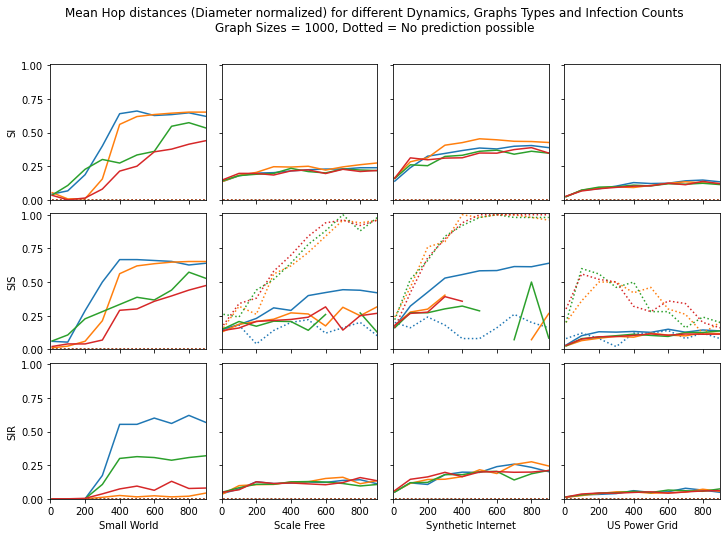

In [23]:
fig = avg_matrix(len(simulations), len(graph_names), len(predictors), infection_counts[0:10], sim_data, sim_names, graph_names, predictor_names, (900, 1.01), (200, 0.25))
fig.suptitle(f"Mean Hop distances (Diameter normalized) for different Dynamics, Graphs Types and Infection Counts\nGraph Sizes = 1000, Dotted = No prediction possible")
plt.show()


Compute invalids and frequency
Draw
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


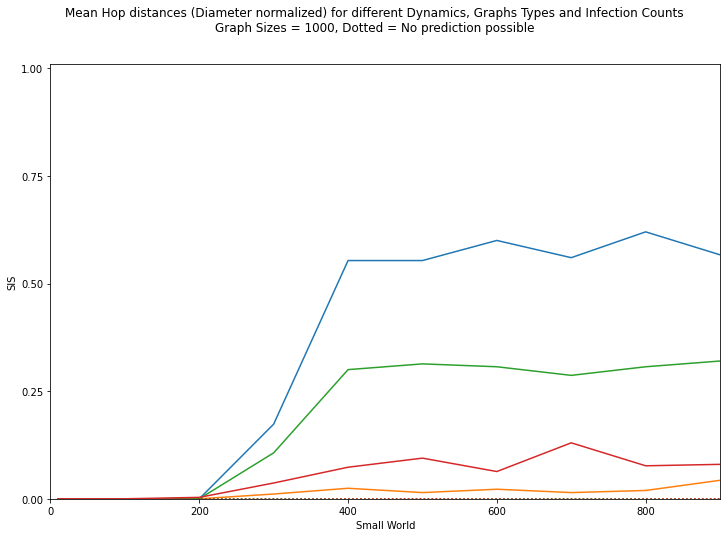

In [61]:
sf_si_data = [[[i[2][0]]] for i in sim_data]
fig = avg_matrix(1, 1, len(predictors), infection_counts[0:10], sf_si_data, [sim_names[1]], [graph_names[0]], predictor_names, (900, 1.01), (200, 0.25))
fig.suptitle(f"Mean Hop distances (Diameter normalized) for different Dynamics, Graphs Types and Infection Counts\nGraph Sizes = 1000, Dotted = No prediction possible")
plt.show()
